<a href="https://colab.research.google.com/github/sangttruong/Sessionality/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time-series Forecasting using Ensemble Learning**
*Author: Sang Truong*

Department of Economics and Management

DePauw University, Greencastle, IN 46135

* Dynamic Harmonic Regression
* State-Space Exponential Smoothing
* k-Nearest Neighbor
* Recurrent Neural Network

Reference: https://otexts.com/fpp2/transformations.html

## **Section 1. Introduction**

Denote variables: 

*   N: Train length



In [6]:
# Colab
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Colab Notebooks/DemandForecast/'

# Scientific computing and database
import math
import pandas as pd
import numpy as np
from scipy.optimize import leastsq # Least square optimizer

# Visualization
import matplotlib.pyplot as plt # Plot
import seaborn as sns # Heatmap
from statsmodels.tsa.seasonal import seasonal_decompose # Seasional decomposition
import statsmodels.graphics.tsaplots as tsaplots # Residual Diagnostic

import statsmodels.tsa.stattools as stattools

# Auto SARIMAX
import statsmodels.tsa.statespace.sarimax as sarimax
! pip install pyramid-arima
from pyramid.arima import auto_arima

# Auto State-Space Exponential Smoothing
! pip install tbats
from tbats import TBATS, BATS

# Alarm
def alarm():
  # Play an audio beep. Any audio URL will do.
  from google.colab import output
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

# Residual diagnostics
# Source: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.plot_diagnostics.html
def plot_diagnostics(self, variable=0, lags=10, fig=None, figsize=(15,7)):
  from statsmodels.graphics.utils import _import_mpl, create_mpl_fig
  _import_mpl()
  fig = create_mpl_fig(fig, figsize)

  # # Eliminate residuals associated with burned or diffuse likelihoods
  # d = np.maximum(self.loglikelihood_burn, self.nobs_diffuse)
  # resid = self.filter_results.standardized_forecasts_error[variable, d:]
  # loglikelihood_burn: the number of observations during which the likelihood is not evaluated.

  # Standardize residual
  # Source: https://alkaline-ml.com/pmdarima/1.1.1/_modules/pmdarima/arima/arima.html
  resid = self
  resid = (resid - np.nanmean(resid)) / np.nanstd(resid)

  # Top-left: residuals vs time
  ax = fig.add_subplot(221)
  if hasattr(self.data, 'dates') and self.data.dates is not None:
      x = self.data.dates[d:]._mpl_repr()
  else:
      x = np.arange(len(resid))
  ax.plot(x, resid)
  ax.hlines(0, x[0], x[-1], alpha=0.5)
  ax.set_xlim(x[0], x[-1])
  ax.set_title('Standardized residual')

  # Top-right: histogram, Gaussian kernel density, Normal density
  # Can only do histogram and Gaussian kernel density on the non-null
  # elements
  resid_nonmissing = resid[~(np.isnan(resid))]
  ax = fig.add_subplot(222)

  # gh5792: Remove  except after support for matplotlib>2.1 required
  try:
      ax.hist(resid_nonmissing, density=True, label='Hist')
  except AttributeError:
      ax.hist(resid_nonmissing, normed=True, label='Hist')

  from scipy.stats import gaussian_kde, norm
  kde = gaussian_kde(resid_nonmissing)
  xlim = (-1.96*2, 1.96*2)
  x = np.linspace(xlim[0], xlim[1])
  ax.plot(x, kde(x), label='KDE')
  ax.plot(x, norm.pdf(x), label='N(0,1)')
  ax.set_xlim(xlim)
  ax.legend()
  ax.set_title('Histogram plus estimated density')

  # Bottom-left: QQ plot
  ax = fig.add_subplot(223)
  from statsmodels.graphics.gofplots import qqplot
  qqplot(resid_nonmissing, line='s', ax=ax)
  ax.set_title('Normal Q-Q')

  # Bottom-right: Correlogram
  ax = fig.add_subplot(224)
  from statsmodels.graphics.tsaplots import plot_acf
  plot_acf(resid, ax=ax, lags=lags)
  ax.set_title('Correlogram')

  ax.set_ylim(-1, 1)

  return fig

# Import data
raw = pd.read_csv(path + 'train.csv')
raw11 = raw[(raw.store == 1) & (raw.item == 1) ]
raw11
N = round(len(raw11)*0.9)

t = np.linspace(1, len(raw11), len(raw11))
t_train = t[:N,]
t_test = t[N:,]

train11 = raw11.iloc[:N,]
test11 = raw11.loc[N:,]

train11

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
1638,2017-06-27,1,1,32
1639,2017-06-28,1,1,50
1640,2017-06-29,1,1,28
1641,2017-06-30,1,1,28


The data is recorded over 5 years: from the begining of 2013 to the end of 2017. We observe a annual seasional period in the data as shown in the below graph. In addition, base on PACF plot, there are a weekly seasional correlation.

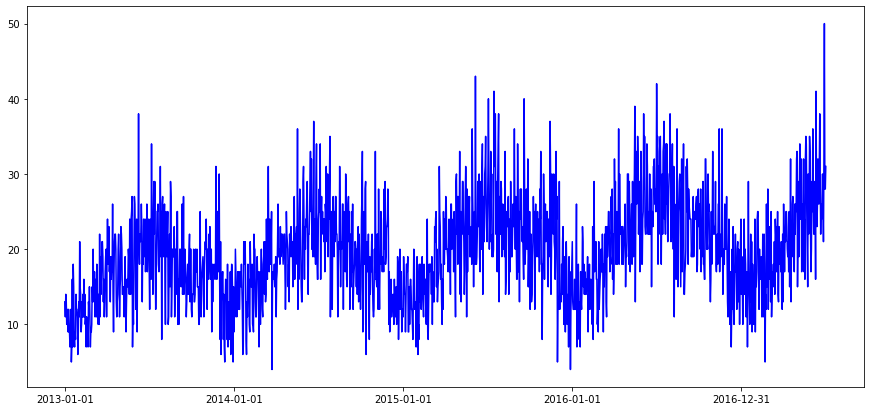

In [0]:
# Plot
plt.figure(figsize = (15,7))
plt.plot(train11.loc[:,'date'], train11.loc[:,'sales'], color='blue')
plt.xticks(np.arange(0, N, 365))
plt.savefig(path + 'figure1.png', quality = 100, dpi = 1000)
plt.show()

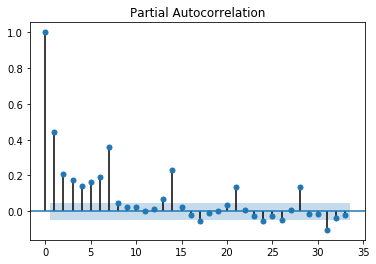

In [0]:
# PACF
pacf = tsaplots.plot_pacf(train11.sales)
pacf.savefig(path + 'pacf.png', quality = 100, dpi = 1000)
pacf.show()

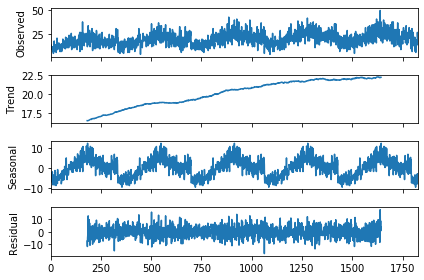

In [0]:
# Decomposition
# STL decomposition: https://github.com/jrmontag/STLDecompose/blob/master/STL-usage-example.ipynb
# STL decomposition 2: https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html
decompose = seasonal_decompose(raw11.sales, model='addictive', freq=365)
decomposeplot = decompose.plot()
decomposeplot.savefig(path + 'decomposeplot.png', quality = 100, dpi = 1000)
decomposeplot.show()

## **Section 2. Baseline**

We explore the forecastability of sinusoidal model (instead of random walk model) as the baseline for forecasting in this paper. Sinusodal model includes the trend component and the seasionality component:

$$ y = \alpha_{0} + \alpha_{1}t + \alpha_{2}sin(\alpha_{3}t + \alpha_{4})$$

We fit this model through the data by minimizing the sum of squared residual (SSE): 

$$ e_i = y_i - \hat{y_i} $$
$$ SSE = \sum_{i=1}^{k} e_i^2$$

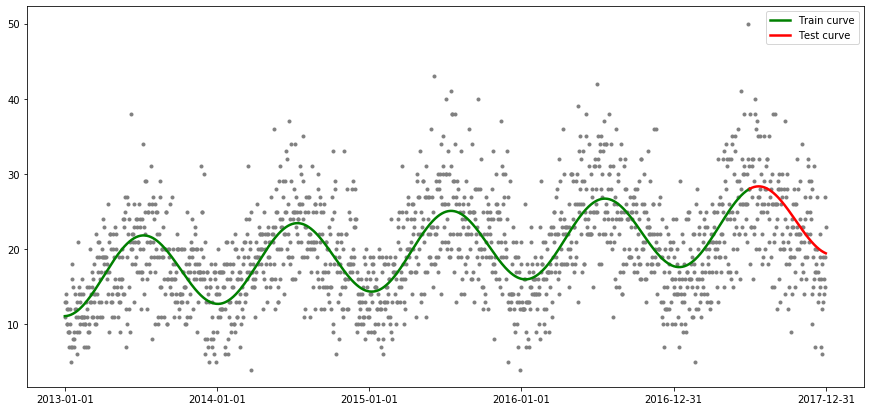

In [0]:
# Generate guest parameters
guess_int = 10
guess_trend = 0.1

guess_amp = 5
guess_freq = 2*3.14/365
guess_phase = 1

# Define the function to optimize: residual
residual = lambda x: train11['sales'] - (x[0] + x[1]*t_train + x[2]*np.sin(x[3]*t_train + x[4]))
result = leastsq(residual, [guess_int, guess_trend, guess_amp, guess_freq, guess_phase], full_output=1)
est_int, est_trend, est_amp, est_freq, est_phase = result[0]

train_curve = (est_int+ est_trend*t_train) + est_amp*np.sin(est_freq*t_train + est_phase)
test_curve =  (est_int+ est_trend*t_test) + est_amp*np.sin(est_freq*t_test + est_phase)

# Error
rmse_train_sin = math.sqrt(sum((train_curve-train11.loc[:,'sales'])**2)/N) #5.357423907854065
rmse_test_sin = math.sqrt(sum((test_curve-test11.loc[:,'sales'])**2)/(len(raw11)-N)) #6.148960372350588

# Plot
plt.figure(figsize=(15,7))
plt.plot(raw11.loc[:,'date'], raw11.loc[:,'sales'], color='blue')
plt.plot(train11.loc[:,'date'], train_curve, label='Train curve', color='green', linewidth = 2.5)
plt.plot(test11.loc[:,'date'], test_curve, label = 'Test curve', color='red', linewidth = 2.5)
plt.xticks(np.arange(0, len(raw11), 365))
plt.legend()
plt.savefig(path + 'figure2.png', quality = 100, dpi = 1000)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Series.data is deprecated and will be removed in a future version


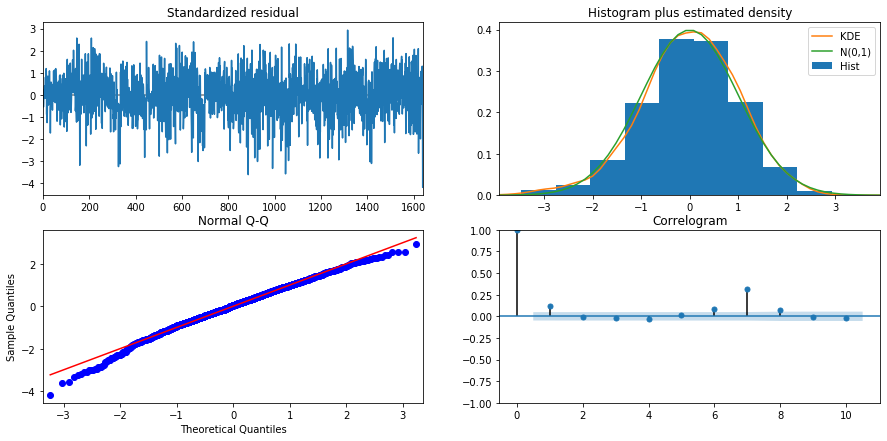

In [0]:
# Residual diagnostic
resdiag_sin = plot_diagnostics(train_curve-train11.loc[:,'sales'])
resdiag_sin.savefig(path + 'resid_sin.png', quality = 100, dpi = 1000)
resdiag_sin.show()

## **Section 3. DHR**

Dynamic harmonic regression with multiple seasonal periods:
* [Rob Hyndman lecture](https://robjhyndman.com/nyc2018/3-1-Dynamic-Regression.pdf)
* [Rob Hyndman textbook chapter](https://otexts.com/fpp2/dhr.html)

Seasional ARIMA (or SARIMA) model includes 7 parameters: p, d, q, P, D, Q, and s. SARIMA(p, d, q)(P, D, Q)s is determined by four following polynomials: 
$$\phi(x) = 1 - \phi_{1}x - \phi_{2}x^2- \phi_{3}x^3 - ... - \phi_{p}x^p = 1 - \sum_{i=1}^{p}\phi_i x^i $$
$$\Phi(x) = 1 - \Phi_{1}x - \Phi_{2}x^2- \Phi_{3}x^3 - ... - \Phi_{p}x^P = 1 - \sum_{i=1}^{P}\Phi_i x^i $$
$$\psi(x) = 1 - \psi_{1}x - \psi_{2}x^2- \psi_{3}x^3 - ... - \psi_{q}x^p = 1 - \sum_{i=1}^{q}\psi_i x^i $$
$$\Psi(x) = 1 - \Psi_{1}x - \Psi_{2}x^2- \Psi_{3}x^3 - ... - \Psi_{Q}x^p = 1 - \sum_{i=1}^{Q}\Psi_i x^i $$

Recall the differential notation for trend-stationalizing time-series:
$$ \nabla_s Y_t = Y_t - Y_{t-s} $$

SARIMA(p, d, q)(P, D, Q)s where $X_t$ is the white noise process:
$$\phi(B)\Phi(B)\nabla^d \nabla_s^D Y_{t} = \psi(B)\Psi(B)X_{t} $$

Note that SARIMA can only model 1 seasional period (by parameter $s$).

When exogenous regressors are included, the [SARIMAX](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) module uses the concept of “regression with SARIMA errors”. 

In [0]:
# Generate Fourier's term for training set
exog = pd.DataFrame({'date': pd.to_datetime(train11['date'])})
exog = exog.set_index(pd.PeriodIndex(exog.date.values, freq='D'))
for i in range(1,16):
  exog['sin365_' + str(i)] = np.sin(2 * i * np.pi * exog.index.dayofyear / 365.25)
  exog['cos365_' + str(i)] = np.cos(2 * i * np.pi * exog.index.dayofyear / 365.25)
exog

,date,sin365_1,cos365_1,sin365_2,cos365_2,sin365_3,cos365_3,sin365_4,cos365_4,sin365_5,cos365_5,sin365_6,cos365_6,sin365_7,cos365_7,sin365_8,cos365_8,sin365_9,cos365_9,sin365_10,cos365_10,sin365_11,cos365_11,sin365_12,cos365_12,sin365_13,cos365_13,sin365_14,cos365_14,sin365_15,cos365_15
2013-01-01,2013-01-01,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.085906,0.996303,0.103031,0.994678,0.120126,0.992759,0.137185,0.990545,0.154204,0.988039,0.171177,0.985240,0.188099,0.982150,0.204966,0.978769,0.221772,0.975099,0.238513,0.971139,0.255182,0.966893
2013-01-02,2013-01-02,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545,0.171177,0.985240,0.204966,0.978769,0.238513,0.971139,0.271777,0.962360,0.304719,0.952442,0.337301,0.941397,0.369484,0.929237,0.401229,0.915978,0.432499,0.901634,0.463258,0.886224,0.493468,0.869764
2013-01-03,2013-01-03,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769,0.255182,0.966893,0.304719,0.952442,0.353445,0.935455,0.401229,0.915978,0.447945,0.894061,0.493468,0.869764,0.537677,0.843151,0.580455,0.814292,0.621687,0.783266,0.661263,0.750154,0.699079,0.715044
2013-01-04,2013-01-04,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360,0.337301,0.941397,0.401229,0.915978,0.463258,0.886224,0.523094,0.852275,0.580455,0.814292,0.635068,0.772456,0.686676,0.726964,0.735034,0.678031,0.779913,0.625889,0.821100,0.570784,0.858402,0.512978
2013-01-05,2013-01-05,0.085906,0.996303,0.171177,0.985240,0.255182,0.966893,0.337301,0.941397,0.416926,0.908940,0.493468,0.869764,0.566362,0.824157,0.635068,0.772456,0.699079,0.715044,0.757922,0.652346,0.811160,0.584824,0.858402,0.512978,0.899296,0.437340,0.933542,0.358468,0.960885,0.276946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-27,2017-06-27,0.079477,-0.996837,-0.158452,0.987367,0.236424,-0.971650,-0.312900,0.949786,0.387397,-0.921913,-0.459442,0.888208,0.528581,-0.848883,-0.594376,0.804187,0.656411,-0.754404,-0.714292,0.699848,0.767655,-0.640864,-0.816160,0.577825,0.859503,-0.511131,-0.897407,0.441204,0.929634,-0.368484
2017-06-28,2017-06-28,0.062318,-0.998056,-0.124395,0.992233,0.185987,-0.982552,-0.246857,0.969052,0.306767,-0.951785,-0.365484,0.930818,0.422781,-0.906232,-0.478434,0.878124,0.532227,-0.846602,-0.583951,0.811789,0.633406,-0.773820,-0.680398,0.732843,0.724745,-0.689017,-0.766275,0.642513,0.804826,-0.593511
2017-06-29,2017-06-29,0.045141,-0.998981,-0.090190,0.995925,0.135055,-0.990838,-0.179645,0.983732,0.223868,-0.974619,-0.267636,0.963520,0.310857,-0.950457,-0.353445,0.935455,0.395312,-0.918547,-0.436373,0.899766,0.476544,-0.879150,-0.515744,0.856742,0.553893,-0.832588,-0.590912,0.806736,0.626727,-0.779239
2017-06-30,2017-06-30,0.027950,-0.999609,-0.055879,0.998438,0.083764,-0.996486,-0.111583,0.993755,0.139315,-0.990248,-0.166938,0.985967,0.194431,-0.980916,-0.221772,0.975099,0.248940,-0.968519,-0.275913,0.961183,0.302670,-0.953095,-0.329192,0.944263,0.355455,-0.934693,-0.381441,0.924393,0.407129,-0.913370


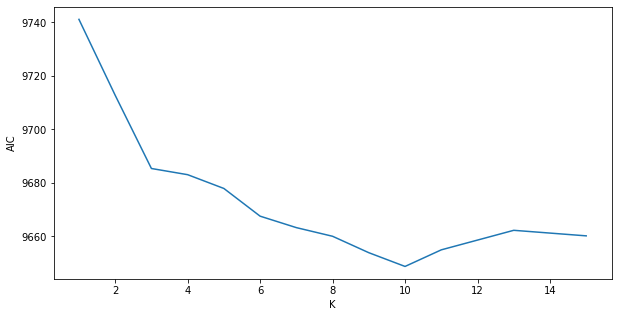

In [0]:
# Hyperparameter K turning
DHR = pd.DataFrame(columns=['K', 'Result', 'AIC'])
for i in range(10,11):
  f = exog.iloc[:,1:(2*i+1)]
  DHR.loc[i, 'K'] = i
  DHR.loc[i,'Result'] = auto_arima(train11['sales'], f, seasonal = True, m = 7)
  DHR.loc[i, 'AIC'] = DHR.loc[i,'Result'].aic()

plt.figure(figsize=(10,5))
plt.plot(DHR.loc[:,'K'], DHR.loc[:, 'AIC'])
plt.xlabel('K')
plt.ylabel('AIC')
plt.savefig(path + 'figure4.png', quality = 100, dpi = 1000)
plt.show()

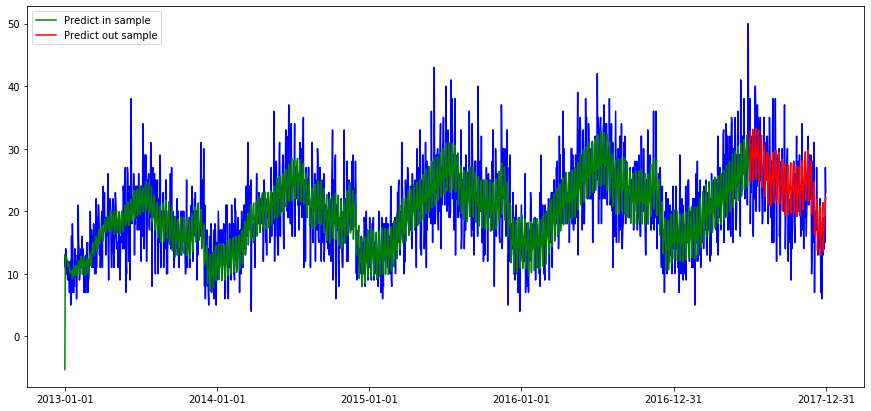

In [0]:
# Generate Fourier's term for testing set
exog_test = pd.DataFrame({'date': pd.to_datetime(test11['date'])})
exog_test = exog_test.set_index(pd.PeriodIndex(exog_test.date.values, freq='D'))
for i in range(1,16):
  exog_test['sin365_' + str(i)] = np.sin(2 * i * np.pi * exog_test.index.dayofyear / 365.25)
  exog_test['cos365_' + str(i)] = np.cos(2 * i * np.pi * exog_test.index.dayofyear / 365.25)

# SARIMAX, K = 10
i = 10
f = exog.iloc[:,1:(2*i+1)]
f_test = exog_test.iloc[:,1:(2*i+1)]
pred_insample = DHR.loc[i,'Result'].predict_in_sample(f)
pred_outsample = DHR.loc[i,'Result'].predict(len(raw11)-N, f_test)

# Error
rmse_train_sarimax = math.sqrt(sum((pred_insample-train11.loc[:,'sales'])**2)/N) #4.5044196406658665
rmse_test_sarimax = math.sqrt(sum((pred_outsample-test11.loc[:,'sales'])**2)/(len(raw11)-N)) #4.900916628354385

# Test
plt.figure(figsize=(15,7))
plt.plot(raw11.loc[:,'date'], raw11.loc[:,'sales'], color = 'blue')
plt.plot(train11.loc[:,'date'], pred_insample, label='Predict in sample', color = 'green')
plt.plot(test11.loc[:,'date'], pred_outsample, label='Predict out sample', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.savefig(path + 'figure5.png', quality = 100, dpi = 1000)
plt.show()

In [0]:
# Best model summary
i = 10
DHR.loc[i,'Result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1643
Model:             SARIMAX(1, 1, 1)x(2, 0, 2, 7)   Log Likelihood               -4796.376
Date:                           Mon, 13 Jan 2020   AIC                           9648.751
Time:                                   14:52:43   BIC                           9800.054
Sample:                                        0   HQIC                          9704.862
                                          - 1643                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.944e-06   2.14e-05      0.137      0.891   -3.91e-05     4.5e-05
x1            -1.5078      0.241     -6.254      0.000      -1.980      -1.035
x2            -4.7613      0.228    -20.852      0.000      -5.209      -4.314
x3            -1.0484      0.178     -5.888      0.000      -1.397      -0.699
x4             0.0366      0.169      0.217      0.828      -0.294       0.367
x5            -0.6788      0.164     -4.128      0.000      -1.001      -0.356
x6            -1.0227      0.172     -5.960      0.000      -1.359      -0.686
x7             0.3125      0.165      1.898      0.058      -0.010       0.635
x8            -0.1490      0.165     -0.903      0.366      -0.472       0.174
x9             0.4666      0.163      2.870      0.004       0.148       0.785
x10           -0.5385      0.163     -3.296      0.001      -0.859      -0.218
x11            0.7436      0.164      4.542      0.000       0.423       1.065
x12           -0.0655      0.160     -0.409      0.683      -0.379       0.248
x13            0.1647      0.162      1.018      0.309      -0.152       0.482
x14            0.2046      0.160      1.280      0.200      -0.109       0.518
x15            0.2525      0.163      1.547      0.122      -0.067       0.572
x16            0.1534      0.159      0.967      0.334      -0.158       0.465
x17            0.0224      0.158      0.141      0.888      -0.288       0.333
x18            0.5017      0.161      3.117      0.002       0.186       0.817
x19           -0.2298      0.157     -1.461      0.144      -0.538       0.078
x20            0.2875      0.161      1.784      0.074      -0.028       0.603
ar.L1          0.0174      0.026      0.677      0.498      -0.033       0.068
ma.L1         -0.9853      0.005   -200.428      0.000      -0.995      -0.976
ar.S.L7        0.0443      0.257      0.172      0.863      -0.460       0.549
ar.S.L14       0.9540      0.257      3.707      0.000       0.450       1.458
ma.S.L7       -0.0235      0.252     -0.093      0.926      -0.518       0.471
ma.S.L14      -0.9389      0.247     -3.800      0.000      -1.423      -0.455
sigma2        19.9468      0.668     29.856      0.000      18.637      21.256
===================================================================================
Ljung-Box (Q):                       41.31   Jarque-Bera (JB):                24.41
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

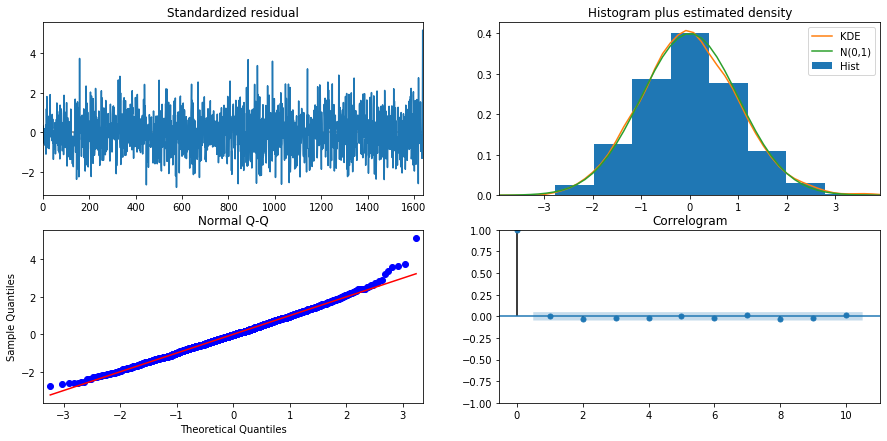

In [0]:
# Residual diagnostic with eliminated residuals associated with burned or diffuse likelihoods
i = 10
f = exog.iloc[:,1:(2*i+1)]
f = f.reset_index(drop = True)
import statsmodels.tsa.statespace.sarimax as sarimax
sarima = sarimax.SARIMAX(train11.sales, exog = f, order=(1, 1, 1), seasonal_order=(2, 0, 2, 7), )
sarima = sarima.fit()
sarima.plot_diagnostics(figsize=(15, 7))
plt.savefig(path + 'resid_DHR.png', quality = 100, dpi = 1000)
plt.show()

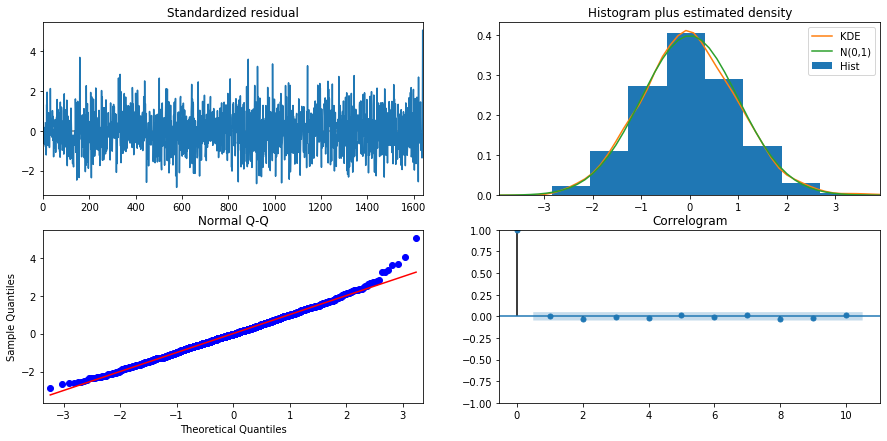

In [0]:
# Residual diagnostic with all residual
i = 10
plot_diagnostics(DHR.loc[i,'Result'].resid()).show()

## **Section 4. TBATS**
[TBATS Documentation](https://pypi.org/project/tbats/)

In [36]:
# Fit the model
estimator = TBATS(use_box_cox = None, use_trend = None, use_damped_trend = None, seasonal_periods=(7, 365.25), use_arma_errors = True)
model = estimator.fit(train11.loc[:,'sales'])

# Summarize fitted model
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [3 5]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.021433
Seasonal Parameters (Gamma): [6.76205557e-09 1.52984727e-08 6.31671864e-10 9.56033709e-09]
AR coefficients []
MA coefficients []
Seed vector [ 1.73515005e+01 -2.60622319e+00 -2.91681871e-01  1.21111329e+00
 -7.15308899e-01  1.82823019e+00  8.97730041e-01 -4.79700119e+00
  2.18630194e-03 -1.05111669e+00 -1.04472647e-01 -4.41500950e-01
 -9.43133873e-01 -1.00299772e+00 -6.12672101e-01  2.58632288e-01
  4.44877906e-01]

AIC 17134.101363


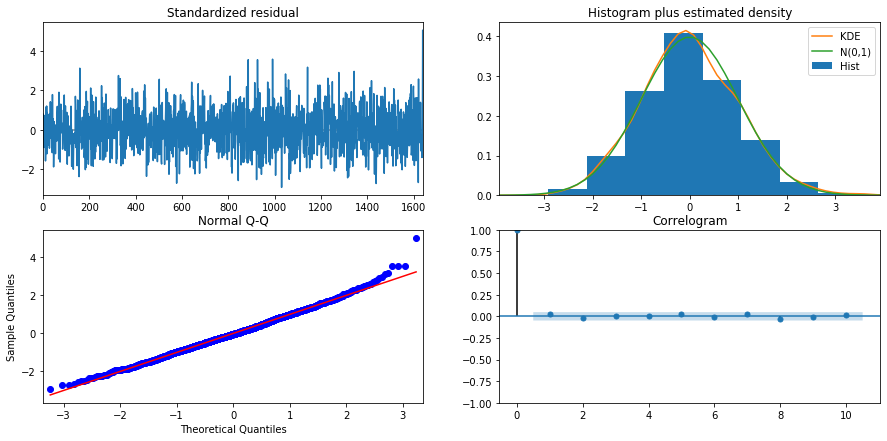

In [0]:
# Residual diagnostic
plot_diagnostics(model.resid).show()

In [84]:
min(e)

-12.884432407506747

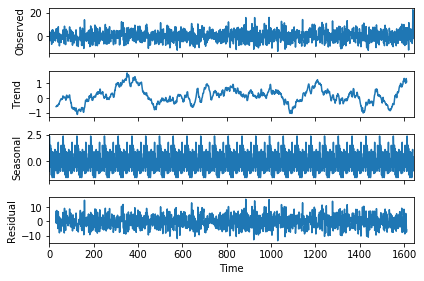

In [91]:
decompose = seasonal_decompose(e, model= 'addictive' , freq = 62)
decomposeplot = decompose.plot()
# decomposeplot.savefig(path + 'decomposeplot.png', quality = 100, dpi = 1000)
decomposeplot.show()

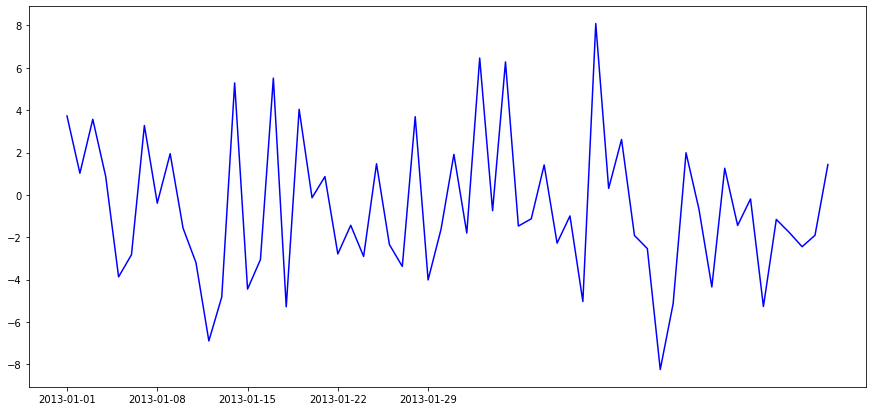

In [65]:
# Plot residual
e = model.resid
plt.figure(figsize=(15,7))
plt.plot(train11.loc[:59,'date'], e[:60], color = 'blue')
plt.xticks(np.arange(0, 30, 7))
# plt.savefig(path + 'figure6TBATSzoom.png', quality = 100, dpi = 1000)
plt.show()

In [0]:
# Predict
y_forecast = model.forecast(steps=len(raw11)-N)

# Error
rmse_train_tbats = math.sqrt(sum((model.y_hat-train11.loc[:,'sales'])**2)/N) #4.476060861375845
rmse_test_tbats = math.sqrt(sum((y_forecast-test11.loc[:,'sales'])**2)/(len(raw11)-N)) #4.709578222905581

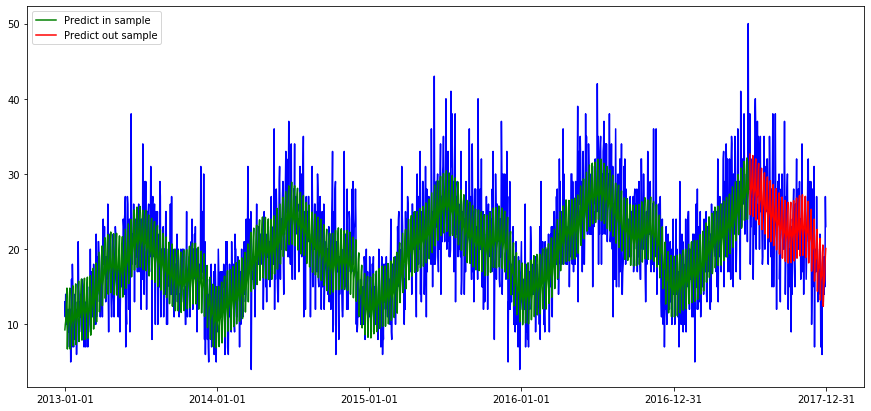

In [0]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(raw11.loc[:,'date'], raw11.loc[:,'sales'], color = 'blue')
plt.plot(train11.loc[:,'date'], model.y_hat, label='Predict in sample', color = 'green')
plt.plot(test11.loc[:,'date'], y_forecast, label='Predict out sample', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.savefig(path + 'figure6.png', quality = 100, dpi = 1000)
plt.show()

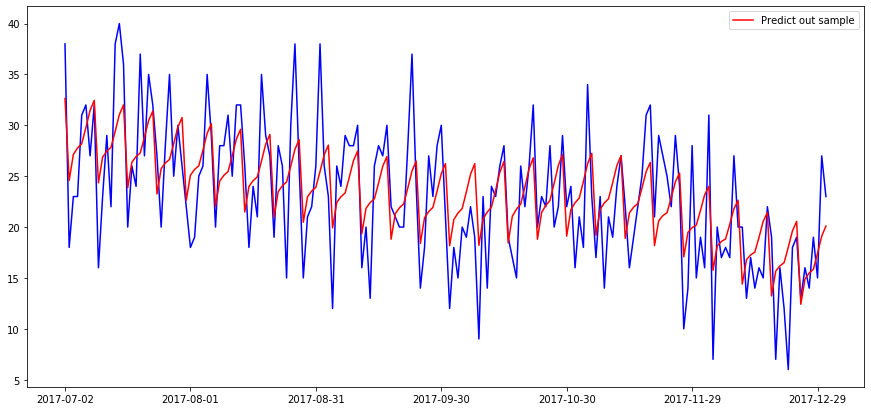

In [55]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(test11.loc[N:,'date'], test11.loc[N:,'sales'], color = 'blue')
# plt.plot(train11.loc[:,'date'], model.y_hat, label='Predict in sample', color = 'green')
plt.plot(test11.date, y_forecast, label='Predict out sample', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(test11), 30))
plt.savefig(path + 'figure6TBATSzoom.png', quality = 100, dpi = 1000)
plt.show()

## **Section 5. KNN**

In [0]:
class KNNRegressor():
  import numpy as np
  def __init__(self, wsize = 10, distFunc = lambda x1, x2: sum(abs(np.array(x1) - np.array(x2))), k = 10, step=1):
    self.inputTS = None
    self.wsize = wsize
    self.distFunc = distFunc
    self.k = k
    self.step = step
    
  def forecast(self, inputTS, seq=False):
    inputTS = np.array(inputTS)

    # Slide the window of wsize
    n = len(inputTS)
    windows = []
    for i in range(n - self.wsize + 1):
      windows.append(inputTS[i : i + self.wsize])
      
    # Take the most recent window and compare with previous window
    recentTS = windows[-1]
    df = pd.DataFrame(columns=['i_forecast', 'dist'])
    for j in range(len(windows) - 1):
      df.loc[j,'dist'] = self.distFunc(windows[j], recentTS)
      df.loc[j, 'i_forecast'] = inputTS[ j + self.wsize]
    df.sort_values(by = ['dist'], inplace = True)
    forecast = np.mean(df.iloc[0:self.k, 0])
    return forecast

    # import scipy.stats
    # def mean_confidence_interval(train11, confidence=0.95):
    #     a = 1.0 * np.array(train11)
    #     n = len(a)
    #     m, se = np.mean(a), scipy.stats.sem(a)
    #     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #     return m-h, m+h
    # ci = mean_confidence_interval(forecast)
      
    # return np.array(forecast).mean(), ci[0], ci[1]

# Match to levels distance
def match_levels(x1, x2):
  x1 = np.array(x1)
  x2 = np.array(x1)
  w = np.array([1/(i+1) for i in range(len(x1))])
  dist = np.sum(np.multiply(w,(x2-x1)**2))
  return dist

# Match to deviations from local mean
def match_dev_local(x1, x2):
  x1 = np.array(x1)
  x2 = np.array(x1)
  x1_dev = x1[i] - x1.mean()
  x2_dev = x2[i] - x2.mean()
  w = np.array([1/(i+1) for i in range(len(x1))])
  dist = np.sum(np.multiply(w,(x2_dev-x1_dev)**2))
  return dist

### **Section 5.1 Vanilla KNN**

In [0]:
# Grid search: hyperparameter turning with out sample forecast
WSIZE = [700]
K = [39]
grid = pd.DataFrame(index=K, columns=WSIZE)

for wsize in WSIZE:
  for k in K:
    nnm = KNNRegressor(wsize = wsize, distFunc = match_levels, k = k)
    preds = pd.DataFrame(columns=['raw11', 'trainKNN', 'KNN'])
    preds.raw11 = raw11.sales
    preds.loc[0:N-1,'trainKNN'] = train11.sales

    for i in range (N-wsize, len(raw11)-wsize):
      x_input = preds.loc[:i+wsize-1,'trainKNN']
      preds.loc[i+wsize,'trainKNN'] = nnm.forecast(x_input)  
      preds.loc[i+wsize,'KNN'] = preds.loc[i+wsize,'trainKNN']

    # Error
    grid.loc[k, wsize] = math.sqrt(sum((preds.loc[N:,'KNN']-test11.loc[:,'sales'])**2)/(len(raw11)-N))
    print(grid)

In [0]:
# Heatmap
sns.heatmap(grid)
# plt.savefig(path + 'heatmapKNN.png', quality = 100, dpi = 1000)

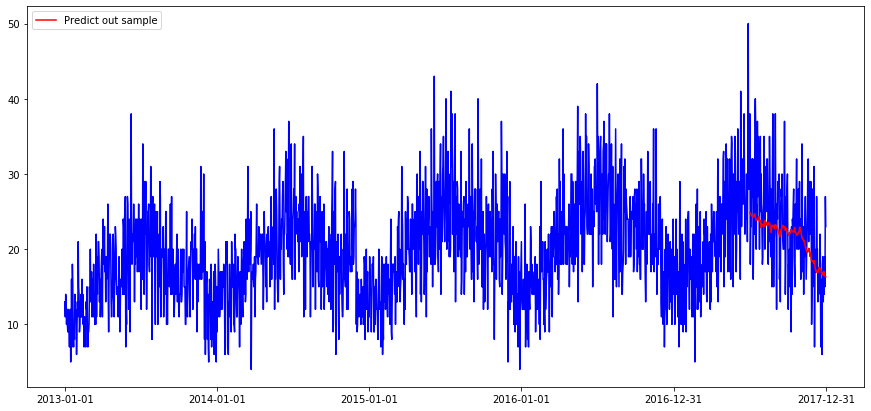

In [0]:
# Plot best KNN
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.sales, color = 'blue')
plt.plot(test11.date, preds.loc[N:,'KNN'], label='Predict out sample', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.savefig(path + 'figure8KNN700_39.png', quality = 100, dpi = 1000)
plt.show()

### **Section 5.2 Detrend-KNN**

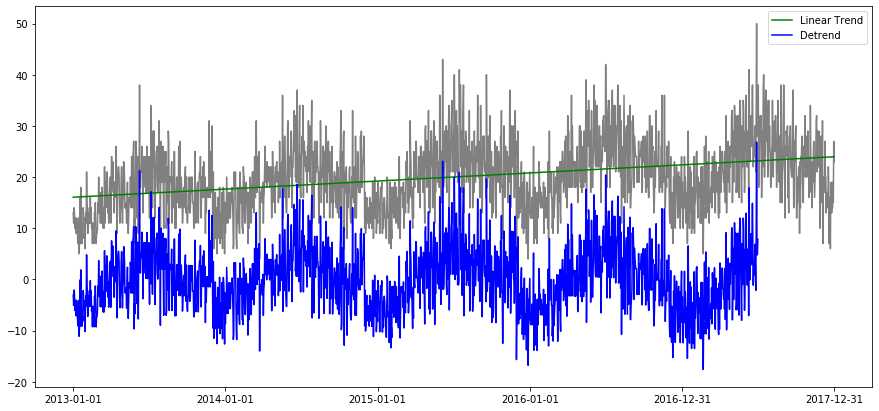

In [0]:
# Detrend
import statsmodels.api as sm
y_train11 = train11.sales
y_raw11 = raw11.sales

x_train11 = np.arange(1,len(train11)+1)
x_train11 = sm.add_constant(x_train11)

x_raw11 = np.arange(1,len(raw11)+1)
x_raw11 = sm.add_constant(x_raw11)

model = sm.OLS(y,x_train11)
results = model.fit()

yhat_train11 = results.predict(x_train11)
yhat_raw11 = results.predict(x_raw11)
detrend= y_train11 - yhat_train11

# print(np.mean(detrend))
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.loc[:,'sales'], color = 'grey')
plt.plot(raw11.date, yhat_raw11, label='Linear Trend', color = 'green')
plt.plot(train11.date, detrend, label='Detrend', color = 'blue')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
# plt.savefig(path + 'detrend.png', quality = 100, dpi = 1000)
plt.show()

In [0]:
# Grid search: hyperparameter turning with out sample forecast
WSIZE = [699,701]
K = [10,20,30,37]
grid = pd.DataFrame(index=K, columns=WSIZE)

for wsize in WSIZE:
  for k in K:
    nnm = KNNRegressor(wsize = wsize, distFunc = match_levels, k = k)
    preds = pd.DataFrame(columns=['raw11', 'trend', 'trainKNN', 'KNN'])
    preds.raw11 = raw11.sales
    preds.trend = yhat_raw11
    preds.loc[0:N-1,'trainKNN'] = detrend

    for i in range (N-wsize, len(raw11)-wsize):
      x_input = preds.loc[:i+wsize-1,'trainKNN']
      preds.loc[i+wsize,'trainKNN'] = nnm.forecast(x_input) + preds.loc[i+wsize,'trend']   
      preds.loc[i+wsize,'KNN'] = preds.loc[i+wsize,'trainKNN']

    # Error
    grid.loc[k, wsize] = math.sqrt(sum((preds.loc[N:,'KNN']-test11.loc[:,'sales'])**2)/(len(raw11)-N))
    print(grid)

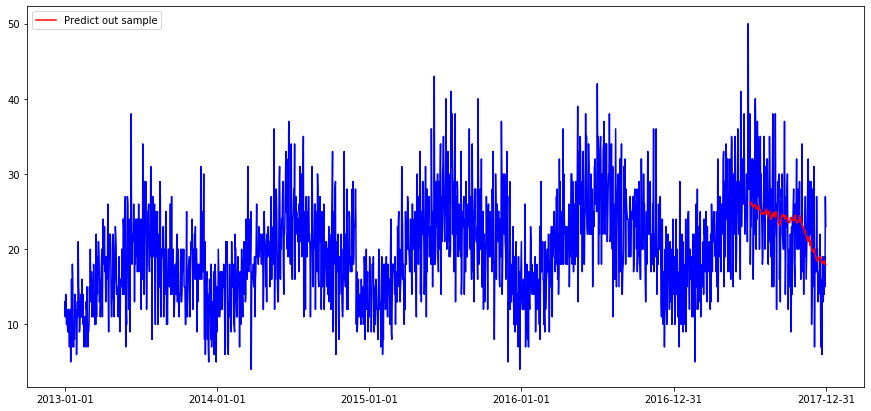

In [0]:
# Plot best KNN
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.sales, color = 'blue')
plt.plot(test11.loc[N:,'date'], preds.loc[N:,'KNN'], label='Predict out sample', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.savefig(path + 'figure9DetrendKNN700_38.png', quality = 100, dpi = 1000)
plt.show()

### **Section 5.3 Bootstrap Detrend-KNN**

In [0]:
# Detrend
import statsmodels.api as sm
y_train11 = train11.sales
y_raw11 = raw11.sales

x_train11 = np.arange(1,len(train11)+1)
x_train11 = sm.add_constant(x_train11)

x_raw11 = np.arange(1,len(raw11)+1)
x_raw11 = sm.add_constant(x_raw11)

model = sm.OLS(y_train11,x_train11)
results = model.fit()

yhat_train11 = results.predict(x_train11)
yhat_raw11 = results.predict(x_raw11)
detrend= y_train11 - yhat_train11
# Grid search: hyperparameter turning with out sample forecast
WSIZE = np.arange(680,700)
K = [38]
grid = pd.DataFrame(index=K, columns=WSIZE)

# Bootstrap
bootstrap = pd.DataFrame()

for wsize in WSIZE:
  for k in K:
    nnm = KNNRegressor(wsize = wsize, distFunc = match_levels, k = k)
    preds = pd.DataFrame(columns=['raw11', 'trend', 'trainKNN', 'KNN'])
    preds.raw11 = raw11.sales
    preds.trend = yhat_raw11
    preds.loc[0:N-1,'trainKNN'] = detrend

    for i in range (N-wsize, len(raw11)-wsize):
      x_input = preds.loc[:i+wsize-1,'trainKNN']
      point_forecast = nnm.forecast(x_input) + preds.loc[i+wsize,'trend']   
      preds.loc[i+wsize,'trainKNN'] = point_forecast
      preds.loc[i+wsize,'KNN'] = point_forecast

    bootstrap = bootstrap.append(preds.loc[N:,'KNN'], ignore_index=True)
    # Error
    grid.loc[k, wsize] = math.sqrt(sum((preds.loc[N:,'KNN']-test11.loc[:,'sales'])**2)/(len(raw11)-N))
    print(grid)
    print(bootstrap)
    bootstrap.to_csv(path + 'bootstrap.csv')
    grid.to_csv(path + 'grid-boostrap-error.csv')

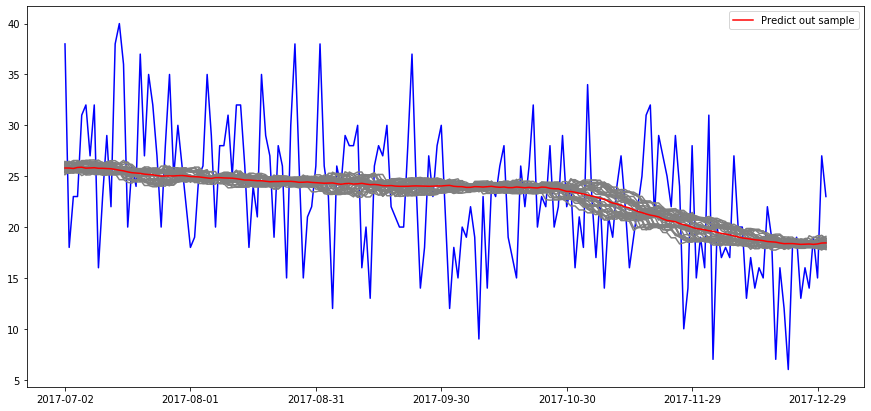

In [32]:
# Recover bootstrap sheet
# Detail: wsize = 700, k = 38, boostrap size = 40, from wsize = 680 to wsize = 720
bootstrap = pd.read_csv(path+"bootstrap680_720.csv", index_col=0, header=0 )
bootstrap = bootstrap.T
boot = bootstrap.mean(axis = 1)
boot = np.array(boot)

# Error
rmse_test_boostrapKNN = math.sqrt(sum((boot-test11.loc[:,'sales'])**2)/(len(raw11)-N)) #6.014778985054232

# Plot bootstrap KNN with wsize = 700 and k = 38, bootstrap size = 40
plt.figure(figsize=(15,7))
plt.plot(test11.date, raw11.loc[N:,'sales'], color = 'blue')
for i in range(680,721):
  plt.plot(test11.date, bootstrap.loc[:,i], color = 'grey')
plt.plot(test11.loc[N:,'date'], boot, label='Predict out sample', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(test11), 30))
plt.savefig(path + 'figure10BoostrapKNN40-700-38.png', quality = 100, dpi = 1000)
plt.show()

## **Section 6. LSTM**
* [Understanding LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/
)
* [Implementation of LSTM](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)


In [0]:
# Univariate stacked lstm
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

# Split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [0]:
# Optimizer
from keras.optimizers import Adam
adam = Adam(clipvalue=0.5) # To avoid gradient explosion

# Number of step to look back
###########################################################################################
n_steps = 10

# Input sequence
raw_seq = train11.sales

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Model architecture
###########################################################################################
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Fit model
model.fit(X, y, epochs=100, verbose=2)

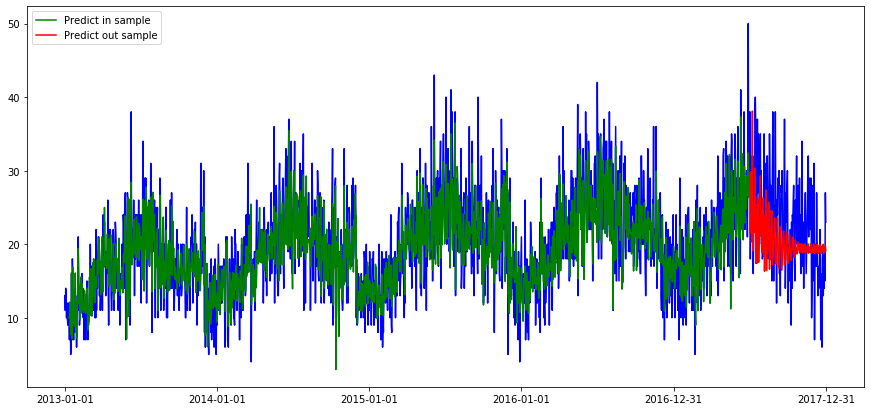

In [0]:
preds = pd.DataFrame(columns=['raw11','step','inSLSTM', 'train-outSLSTM', 'outSLSTM'])
preds.raw11 = raw11.sales

# In sample forecast
for i in range (0, N-n_steps):
  x_input = np.array(preds.loc[i:i+n_steps-1,'raw11'])
  x_input = x_input.reshape((1, n_steps, n_features))
  preds.loc[i+n_steps, 'step'] = i+n_steps   
  preds.loc[i+n_steps,'inSLSTM'] = model.predict(x_input, verbose=0).flatten()[0]
  
# Out sample rolling forecast
preds.loc[0:N-1,'train-outSLSTM'] = train11.sales
for i in range (N-n_steps, len(raw11)-n_steps):
  x_input = np.array(preds.loc[i:i+n_steps-1,'train-outSLSTM'])
  x_input = x_input.reshape((1, n_steps, n_features))
  preds.loc[i+n_steps,'train-outSLSTM'] = model.predict(x_input, verbose=0).flatten()[0]  
  preds.loc[i+n_steps,'outSLSTM'] = model.predict(x_input, verbose=0).flatten()[0]

# Error
rmse_train_LSTM = math.sqrt(sum((preds.loc[n_steps:N-1, 'inSLSTM']-train11.loc[n_steps:,'sales'])**2)/N) #4.352483949025942
rmse_test_LSTM = math.sqrt(sum((preds.loc[N:,'outSLSTM']-test11.loc[:,'sales'])**2)/(len(raw11)-N)) #7.034124914751039

# Plot
plt.figure(figsize=(15,7))
plt.plot(raw11.loc[:,'date'], raw11.loc[:,'sales'], color = 'blue')
plt.plot(train11.loc[n_steps:N-1,'date'], preds.loc[n_steps:N-1, 'inSLSTM'], label='Predict in sample', color = 'green')
plt.plot(test11.loc[N:,'date'], preds.loc[N:,'outSLSTM'], label='Predict out sample', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
# plt.savefig(path + 'figure8.png', quality = 100, dpi = 1000)
plt.show()

In [0]:
rmse_test_LSTM
# 60: 48.54872346001512
# 30: 20.560956684080804
# 15: 8.733966544864794
# 12: 7.68966323306075
# 11: 9.5826788486822
# 10: 6.63700341610319
# 9: 8.04535863965259
# 7: 7.527709369380126

7.277061111022081